# IBM Applied Data Science Capstone Project: Taspas Restaurant in Madrid

## Introduction:
This project aims to utilize data science concepts and machine learning tools to solve a popular problem for restaurant owners in Madrid, Spain: where is the best neighborhood to open a tapas restaurant? In this project, I will go through the processes of problem definition, data preparation, and use machine learning to improve business decisions.

Madrid is the capital and most-populous city of Spain. The Madrid urban agglomeration has the third-largest GDP in the European Union and its influence in politics, education, entertainment, environment, media, fashion, science, culture, and the arts all contribute to its status as one of the world's major global cities.

Madrid is reputed to have a "vibrant nightlife". It is one of the city's main attractions with tapas bars, cocktail bars, clubs, jazz lounges, live music venues and flamenco theatres. That makes Madrid a great place for entrepreneurs to start and grow their business.

## Description and Background of the Problem:

As we know, choosing a neighborhood and location for a restaurant is an important and diffucult step for the entrepreneurs. Most of time it can be as crucial factor as menu quality and service for the restaurant's success. The neighborhood is not only an important factor for customers but also it affects the restaurant quality, including the menu, interior design, style of furnitures.

Then, to choose a the location for the restaurant, we divide the  project into two  parts:

1. we take  into account the sugestions of the article [4 Important Factors When Choosing a Location to Open a Restaurant](https://www.thebalancesmb.com/choosing-a-location-for-your-restaurant-2888635) which are
    * Parking. A restaurant should has its own parking lot. If that isn’t an option (for example, in a major cities), consider partnering with a hotel in the area that has its own parking options. Also it has an acceptable distance to public parking lots.
    * Accessibility. There’s a reason that major restaurant chains are often located near highway exits: It makes them accessible for customers. Also it is a good option to close distance to public transportations. Light Rail Station, Metro Station, Train/Tram Station, Bus Stop around the restaurant is provide convenience for customers.
    * Visibility. This goes along with accessibility and is very important for new restaurant locations. People have to know the restaurant is there, either in person or on their mobile devices.
    * Population Base. There need to be enough people who live in or pass through the area regularly to keep the restaurant busy. So "the particular area's population base" is another important factor about suitable place for a new restaurant.
    Due to Madrid has a very crowded city with huge number of tourists, the Population Base is negligible. The Visibility is out of  the scope of this project. It is hard to keep in view, because it needs different type of data like usage density of every streets, frequently prefered routas and the prefered reason, etc. May be a field research is also needed. Anyway, because of the diffuculties, we focused on Parking and Accessibility and collected data about them.

2. From the first part we take the best thirty neighborhood with better parking and  accessibility factor. Then, we will use Foursquare API to find the top 100 venues within a radius of 1000 meters of the center of that neighborhoods. Finally, we wiil run k-means clustering on the data to cluster neighborhoods.

## Description of the Data:
For solving the problem, we need different type of data. Which are:

*  List of neighborhoods of [Madrid](https://datos.madrid.es/egob/catalogo/200078-1-distritos-barrios.csv)
*  Car Parking list and their geolocations of Madrid.
*  Light Rail/Metro/Train/Tram/Bus Station list and their geolocations of Madrid

For the first point we use Google Geoencoding API to find the approximate coordinates of the neighborhoods. And for the second and third datasets we get the datasets from the Foursquare API.

The important disadvantage of API is the response limit of queries. In every query, the response of venues list limited as 100 result. So, we tried to send query with sub-categoryIDs of venues' (which is exist in Foursquare web site) and update the dataframe with "for loop" easily. we explained this detail later also.

## Target Audience
The target audience of this project would be anyone that is interested in opening a tapas restaurant in Madrid, Spain. The cluster analysis of Madrid neighborhoods will help entrepreneurs make an informed decision about which neighborhoods to aim for.

### Disclaimer
It is only a capstone final project and it is not claimed that the result of the project is 100% proper for trade and investing industry.

In [1]:
import pandas as pd
import numpy as np
import folium # map rendering library

import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.cluster import KMeans
print('Libraries imported.')

Libraries imported.


In [2]:
#get the dataset for  the Madrid neighborhoods
url = 'https://datos.madrid.es/egob/catalogo/200078-1-distritos-barrios.csv'
madrid_raw = pd.read_csv('barrios.csv',delimiter=';',encoding = "ISO-8859-1")
madrid_raw.head()

,Codigo de barrio,Codigo de distrito al que pertenece,Nombre de barrio,Nombre acentuado del barrio,Superficie (m2),Perimetro (m)
0,1,1,PALACIO,PALACIO,1471085,5754
1,1,2,IMPERIAL,IMPERIAL,967500,4557
2,1,3,PACIFICO,PACÍFICO,750065,4005
3,1,4,RECOLETOS,RECOLETOS,870857,3927
4,1,5,EL VISO,EL VISO,1708046,5269


In [3]:
columns = ['Codigo de barrio','Codigo de distrito al que pertenece','Nombre acentuado del barrio','Superficie (m2)','Perimetro (m)']
madrid_tmp = madrid_raw.drop(columns, axis=1).rename(columns={'Nombre de barrio':'Neighborhood'})
madrid_tmp.head()

,Neighborhood
0,PALACIO
1,IMPERIAL
2,PACIFICO
3,RECOLETOS
4,EL VISO


In [5]:
# Adding Madrid, Spain to the neighborhood names to ensure google maps gets the correct data 

madrid_tmp['Neighborhood'] = madrid_tmp['Neighborhood'] + ', Madrid, Spain'
madrid_tmp.head()

,Neighborhood
0,"PALACIO , Madrid, Spain, Madrid, S..."
1,"IMPERIAL , Madrid, Spain, Madrid, S..."
2,"PACIFICO , Madrid, Spain, Madrid, S..."
3,"RECOLETOS , Madrid, Spain, Madrid, S..."
4,"EL VISO , Madrid, Spain, Madrid, S..."


In [6]:
# Get latitude and longtitude coordinates from Google Geoencoding API 

import googlemaps
# Code to add the latitudes and longtitudes to the dataframe
gmaps_key = googlemaps.Client(key = '')

madrid_tmp['Lat'] = None
madrid_tmp['Lon'] = None

for i in range(0, len(madrid_tmp), 1):
    geocode_result = gmaps_key.geocode(madrid_tmp.iat[i,0])
    try:
        lat = geocode_result[0]['geometry']['location']['lat']
        lon = geocode_result[0]['geometry']['location']['lng']
        madrid_tmp.iat[i, madrid_tmp.columns.get_loc('Lat')]= lat
        madrid_tmp.iat[i, madrid_tmp.columns.get_loc('Lon')]= lon
    except:
        lat = None
        lon = None

In [7]:
print(madrid_tmp.dtypes)
madrid_tmp

Neighborhood    object
Lat             object
Lon             object
dtype: object


,Neighborhood,Lat,Lon
0,"PALACIO , Madrid, Spain, Madrid, S...",40.4163,-3.71432
1,"IMPERIAL , Madrid, Spain, Madrid, S...",40.4068,-3.72009
2,"PACIFICO , Madrid, Spain, Madrid, S...",40.4041,-3.67794
3,"RECOLETOS , Madrid, Spain, Madrid, S...",40.4214,-3.68956
4,"EL VISO , Madrid, Spain, Madrid, S...",40.449,-3.68668
...,...,...,...
126,"CANILLEJAS , Madrid, Spain, Madrid, S...",40.4438,-3.61466
127,"EL GOLOSO , Madrid, Spain, Madrid, S...",40.5562,-3.70402
128,"ATALAYA , Madrid, Spain, Madrid, S...",40.4659,-3.66658
129,"EL SALVADOR , Madrid, Spain, Madrid, S...",40.4444,-3.63065


In [8]:
#Great!! we have the latitude and longtitude coordinates for tha Madrid  neighborhoods
#Now need to change the type of the latitude and longtitude columns to a float
madrid_tmp['Lat'] = pd.to_numeric(madrid_tmp['Lat'], errors='coerce')
madrid_tmp['Lon'] = pd.to_numeric(madrid_tmp['Lon'], errors='coerce')
madrid_tmp.dtypes

Neighborhood     object
Lat             float64
Lon             float64
dtype: object

In [9]:
#check is there are some NaNs
madrid_tmp.isnull().values.any()

False

In [10]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Madrid'
geolocator = Nominatim(user_agent="myapp")
location = geolocator.geocode(address)
mad_latitude = location.latitude
mad_longitude = location.longitude
print(f'The geograpical coordinate of Madrid is: {mad_latitude}, {mad_longitude}')

The geograpical coordinate of Madrid is: 40.4167047, -3.7035825


In [11]:
#After finding the latitudes and longitutdes of the neighborhoods, 
#we can then use Folium to map out all these neighborhoods:
map_madrid = folium.Map(location=[mad_latitude, mad_longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(madrid_tmp['Lat'], madrid_tmp['Lon'], madrid_tmp['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

In [121]:
from IPython.display import Image
from IPython.core.display import HTML 
display(Image(url= "https://raw.githubusercontent.com/friverap/Coursera_Capstone/main/madrid_neighborhood.png"))

In [13]:
#create 2 new columns, which we use them in the later on for comparing the neighborhoods
madrid_tmp['CarPark_Dist']=0.0
madrid_tmp['Close_Bus/Train']=0
madrid_tmp.dtypes

Neighborhood        object
Lat                float64
Lon                float64
CarPark_Dist       float64
Close_Bus/Train      int64
dtype: object

## Create DataSets For Comparison
We need 2 datasets for comparison between the neighborhoods

* Car Parking list and their geolocations of Madrid
* Light Rail/Metro/Train/Tram/Bus Station list and their geolocations of Madrid

We can get these datas via Foursquare Api. Firstly, we establish the Foursquare API.

In [125]:
#Define Foursquare parametrs
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


### We can reach Parking Lots Locations via Foursquare Api with Parking CategaoryId. In [Foursquare](https://developer.foursquare.com/docs/build-with-foursquare/categories/), we learned that the categoryId of Parking is "4c38df4de52ce0d596b336e1"

In [15]:

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
categoryId='4c38df4de52ce0d596b336e1' #categoryId of Parking

#create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    mad_latitude, 
    mad_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=ZZ5HDB4K1EL4Z3DCOX3101TRBVCK0SE44VWJ1EUWA0G4P3NU&client_secret=30MFLRQ3BU0RJLFYGZT4UPVKBUCJ3W5QIHK5FMJR1IOGB523&v=20180604&ll=40.4167047,-3.7035825&radius=1000&categoryId=4c38df4de52ce0d596b336e1&limit=100'

In [16]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '601d92f7faf0227239467d15'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Sol',
  'headerFullLocation': 'Sol, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'query': 'parking',
  'totalResults': 30,
  'suggestedBounds': {'ne': {'lat': 40.42570470900001,
    'lng': -3.6917834416936883},
   'sw': {'lat': 40.407704690999985, 'lng': -3.7153815583063117}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd5d76c7b1876b083788b86',
       'name': 'Parking Sevilla',
       'location': {'address': 'Calle de Sevilla, 2',
        'lat': 40.41767408448304,
        'lng': -3.6998060701936386,
        'labeledLatLngs': [{'label': 'display',
     

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
#Now we are ready to clean the json data and structure it into a pandas dataframe as df_park
parking = results['response']['groups'][0]['items']
    
df_park = json_normalize(parking) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_park =df_park.loc[:, filtered_columns]

# filter the category for each row
df_park['venue.categories'] = df_park.apply(get_category_type, axis=1)


# clean columns
df_park.columns = [col.split(".")[-1] for col in df_park.columns]

df_park.head()

<ipython-input-18-d1367e72e5cb>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_park = json_normalize(parking) # flatten JSON


,name,categories,lat,lng
0,Parking Sevilla,Parking,40.417674,-3.699806
1,Parking Jacinto Benavente,Parking,40.414422,-3.703512
2,Parking Plaza del Carmen,Parking,40.419027,-3.703272
3,Parking Santa Ana,Parking,40.414807,-3.700232
4,Parking Plaza de las Descalzas,Parking,40.418063,-3.706297


In [19]:
print('{} parking lots were returned by Foursquare.'.format(df_park.shape[0]))

28 parking lots were returned by Foursquare.


## DataSet of Bus/Train Stops

We can reach Bus/Train Stops Locations via [Foursquare](https://developer.foursquare.com/docs/build-with-foursquare/categories/) Api with CategaoryId. In Foursquare web site, we learned that the categoryIds as;

1. Light Rail Station categoryId is "4bf58dd8d48988d1fc931735"
2. Metro Station categoryId is "4bf58dd8d48988d1fd931735"
4. Bus Station categoryId is "4bf58dd8d48988d1fe931735

In [20]:
#create the Bus/Train Stops categoryID List:
category_list=['4bf58dd8d48988d1fc931735','4bf58dd8d48988d1fd931735','4bf58dd8d48988d1fe931735'] #bus/train station
c=0
df_trans_tot=pd.DataFrame()

In [21]:
#For get the more than 100 response via Foursquare, we send 4 different categoryID in a for loop. 
#We create a a pandas dataframe as df_trans and update them into new a pandas dataframe as df_trans_tot

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

   
#Create a for loop
for c in range(len(category_list)):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    mad_latitude, 
    mad_longitude, 
    radius,
    category_list[c],
    LIMIT)
    print(url) #check the URLs
    
    #Send the GET request and examine the resutls    
    results = requests.get(url).json()  
    transportation = results['response']['groups'][0]['items']
    df_trans = json_normalize(transportation) # flatten JSON  
   
    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']
    
## Now we are ready to clean the json data and structure it into a pandas dataframe as df_trans
    
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    df_trans =df_trans.loc[:, filtered_columns]
    
    # filter the category for each row
    df_trans['venue.categories'] = df_trans.apply(get_category_type, axis=1)
    
    # clean columns
    df_trans.columns = [col.split(".")[-1] for col in df_trans.columns]

    print('For Category ID {} : {}'.format(category_list[c], df_trans.shape))
    
    # Update the dataframe
    df_trans_tot=df_trans_tot.append(df_trans).reset_index(drop=True)

https://api.foursquare.com/v2/venues/explore?&client_id=ZZ5HDB4K1EL4Z3DCOX3101TRBVCK0SE44VWJ1EUWA0G4P3NU&client_secret=30MFLRQ3BU0RJLFYGZT4UPVKBUCJ3W5QIHK5FMJR1IOGB523&v=20180604&ll=40.4167047,-3.7035825&radius=1000&categoryId=4bf58dd8d48988d1fc931735&limit=100


<ipython-input-21-c52f37a097e4>:24: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_trans = json_normalize(transportation) # flatten JSON


For Category ID 4bf58dd8d48988d1fc931735 : (1, 4)
https://api.foursquare.com/v2/venues/explore?&client_id=ZZ5HDB4K1EL4Z3DCOX3101TRBVCK0SE44VWJ1EUWA0G4P3NU&client_secret=30MFLRQ3BU0RJLFYGZT4UPVKBUCJ3W5QIHK5FMJR1IOGB523&v=20180604&ll=40.4167047,-3.7035825&radius=1000&categoryId=4bf58dd8d48988d1fd931735&limit=100
For Category ID 4bf58dd8d48988d1fd931735 : (20, 4)
https://api.foursquare.com/v2/venues/explore?&client_id=ZZ5HDB4K1EL4Z3DCOX3101TRBVCK0SE44VWJ1EUWA0G4P3NU&client_secret=30MFLRQ3BU0RJLFYGZT4UPVKBUCJ3W5QIHK5FMJR1IOGB523&v=20180604&ll=40.4167047,-3.7035825&radius=1000&categoryId=4bf58dd8d48988d1fe931735&limit=100
For Category ID 4bf58dd8d48988d1fe931735 : (10, 4)


In [22]:
df_trans_tot.head()

,name,categories,lat,lng
0,Trem Bala,Light Rail Station,40.419990,-3.704340
1,Metro Sol,Metro Station,40.416882,-3.703038
2,Metro Gran Vía,Metro Station,40.420020,-3.701794
3,Cercanías Sol,Train Station,40.416943,-3.703006
4,Metro Callao,Metro Station,40.420165,-3.705790


In [23]:
print('Total Light Rail/Metro/Train/Tram/Bus Station is:',df_trans_tot.shape[0])

Total Light Rail/Metro/Train/Tram/Bus Station is: 31


### Merge the dataframes madrid_tmp, df_park, and df_trans_tot
 
Fist of all, we calculate the average distance of all "parking lot" for each neighborhood. While we calculate the distance, we limit the distance with three digit after decimal point.

Then, we add the result to the "CarPark_Dist" column of the df dataframe.

In [24]:
from geopy.distance import geodesic
from statistics import mean
#Average Distance Between Parking Lots and Neighborhoods
geolocator = Nominatim(user_agent="myapp")
n=0
m=0
dist_list=[]
while True:
    if n < madrid_tmp['Neighborhood'].count():
        for m in range(df_park['name'].count()):
            location1=list(madrid_tmp.loc[n,'Lat':'Lon'])
            location2=list(df_park.loc[m,'lat':'lng'])
            dist=float('%.2f' % geodesic(location1,location2).m)
            dist_list.append(dist)
        print('{} {} is: {} meters'.format(n+1,(madrid_tmp.loc[n,'Neighborhood']),('%.2f' % mean(dist_list))))
        madrid_tmp.loc[madrid_tmp.index[n], 'CarPark_Dist'] = ('%.2f' % mean(dist_list)) #Update The Neighborhood DataFrame
        madrid_tmp['CarPark_Dist']=pd.to_numeric(madrid_tmp['CarPark_Dist']) #Change the 'CarPark Dist' Column Type as float
        n+=1
    else:
        print('The average distance of all {} parking lots calculated for all {} \n \
        neighborhoods and added to Madrid dataframe'.format((df_park.shape[0]), madrid_tmp.shape[0]))
        break

1 PALACIO             , Madrid, Spain, Madrid, Spain is: 1008.48 meters
2 IMPERIAL            , Madrid, Spain, Madrid, Spain is: 1483.29 meters
3 PACIFICO            , Madrid, Spain, Madrid, Spain is: 1902.74 meters
4 RECOLETOS           , Madrid, Spain, Madrid, Spain is: 1752.70 meters
5 EL VISO             , Madrid, Spain, Madrid, Spain is: 2141.15 meters
6 BELLAS VISTAS       , Madrid, Spain, Madrid, Spain is: 2427.76 meters
7 GAZTAMBIDE          , Madrid, Spain, Madrid, Spain is: 2379.27 meters
8 EL PARDO            , Madrid, Spain, Madrid, Spain is: 3671.29 meters
9 CASA DE CAMPO       , Madrid, Spain, Madrid, Spain is: 3691.00 meters
10 LOS CARMENES        , Madrid, Spain, Madrid, Spain is: 3658.90 meters
11 COMILLAS            , Madrid, Spain, Madrid, Spain is: 3608.01 meters
12 ORCASITAS           , Madrid, Spain, Madrid, Spain is: 3772.90 meters
13 ENTREVIAS           , Madrid, Spain, Madrid, Spain is: 3877.24 meters
14 PAVONES             , Madrid, Spain, Madrid, Spain is: 40

In [64]:
#Now for the Close_Bus/Train
#Bus/Train Station Number in Neighborhood

geolocator = Nominatim(user_agent="myapp")
n=0
m=0
p=0
while True:
    if n < madrid_tmp['Neighborhood'].count():
        for m in range(df_trans_tot['name'].count()):
            location1=list(madrid_tmp.loc[n,'Lat':'Lon'])
            location2=list(df_trans_tot.loc[m,'lat':'lng'])
            dist=float('%.2f' % geodesic(location1,location2).m)
            if dist<=1000: #We set 1 km distance
                p+=1
        print(n+1, madrid_tmp.loc[n,'Neighborhood'],'has:', p, 'close bus/train stop')
        madrid_tmp.loc[madrid_tmp.index[n], 'Close_Bus/Train'] = p #Update The Neighborhood DataFrame
        n+=1
        p = 0
    else:
        print('The total number of all {} close Bus/Train stops for all {} \n \
        neighborhood is calculated and added to Madrid dataframe'.format((df_trans_tot.shape[0]), madrid_tmp.shape[0]))
        break

1 PALACIO             , Madrid, Spain, Madrid, Spain has: 13 close bus/train stop
2 IMPERIAL            , Madrid, Spain, Madrid, Spain has: 0 close bus/train stop
3 RECOLETOS           , Madrid, Spain, Madrid, Spain has: 10 close bus/train stop
4 PACIFICO            , Madrid, Spain, Madrid, Spain has: 0 close bus/train stop
5 EL VISO             , Madrid, Spain, Madrid, Spain has: 0 close bus/train stop
6 GAZTAMBIDE          , Madrid, Spain, Madrid, Spain has: 0 close bus/train stop
7 BELLAS VISTAS       , Madrid, Spain, Madrid, Spain has: 0 close bus/train stop
8 COMILLAS            , Madrid, Spain, Madrid, Spain has: 0 close bus/train stop
9 LOS CARMENES        , Madrid, Spain, Madrid, Spain has: 0 close bus/train stop
10 EL PARDO            , Madrid, Spain, Madrid, Spain has: 0 close bus/train stop
11 CASA DE CAMPO       , Madrid, Spain, Madrid, Spain has: 0 close bus/train stop
12 ORCASITAS           , Madrid, Spain, Madrid, Spain has: 0 close bus/train stop
13 ENTREVIAS           

In [65]:
madrid_tmp.head()

,Neighborhood,Lat,Lon,CarPark_Dist,Close_Bus/Train
0,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,1008.48,13
1,"IMPERIAL , Madrid, Spain, Madrid, S...",40.406845,-3.720088,1483.29,0
2,"RECOLETOS , Madrid, Spain, Madrid, S...",40.421446,-3.689557,1752.70,10
3,"PACIFICO , Madrid, Spain, Madrid, S...",40.404145,-3.677941,1902.74,0
4,"EL VISO , Madrid, Spain, Madrid, S...",40.449021,-3.686681,2141.15,0


In [66]:
#save the final data frame (just in case)
madrid_tmp.to_csv('madrid.csv')

###  Comparison of Neighborhoods
In this step we can start to comparison of neighborhoods to determine the best suitable location for a new restaurant in Madrid. We sort the neighborhods from the average distance of parking lots and create a new dataframe as df with first 30 neighborhods.

In [67]:
madrid_tmp=madrid_tmp.sort_values('CarPark_Dist', ascending=True).reset_index(drop=True)
df=madrid_tmp.head(30)
df.head()

,Neighborhood,Lat,Lon,CarPark_Dist,Close_Bus/Train
0,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,1008.48,13
1,"IMPERIAL , Madrid, Spain, Madrid, S...",40.406845,-3.720088,1483.29,0
2,"RECOLETOS , Madrid, Spain, Madrid, S...",40.421446,-3.689557,1752.70,10
3,"PACIFICO , Madrid, Spain, Madrid, S...",40.404145,-3.677941,1902.74,0
4,"EL VISO , Madrid, Spain, Madrid, S...",40.449021,-3.686681,2141.15,0


In [68]:
#Before starting to compare, we normalize the data in "CarPark_Dist" and "CloseBus/Train"
#columns and create 2 new columns as 'CarPark_DistN' and _'Close_Bus/TrainN'.
df['CarPark_Dist_N']=df['CarPark_Dist'].max()-df.CarPark_Dist
df['CarPark_Dist_N']=df['CarPark_Dist_N']/df['CarPark_Dist_N'].max()
df['Close_Bus/Train_N'] = df['Close_Bus/Train']/df['Close_Bus/Train'].max() #normalize
df.head()


<ipython-input-68-e273458e1709>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CarPark_Dist_N']=df['CarPark_Dist'].max()-df.CarPark_Dist
<ipython-input-68-e273458e1709>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CarPark_Dist_N']=df['CarPark_Dist_N']/df['CarPark_Dist_N'].max()
<ipython-input-68-e273458e1709>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,Neighborhood,Lat,Lon,CarPark_Dist,Close_Bus/Train,CarPark_Dist_N,Close_Bus/Train_N
0,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,1008.48,13,1.000000,1.000000
1,"IMPERIAL , Madrid, Spain, Madrid, S...",40.406845,-3.720088,1483.29,0,0.871075,0.000000
2,"RECOLETOS , Madrid, Spain, Madrid, S...",40.421446,-3.689557,1752.70,10,0.797922,0.769231
3,"PACIFICO , Madrid, Spain, Madrid, S...",40.404145,-3.677941,1902.74,0,0.757181,0.000000
4,"EL VISO , Madrid, Spain, Madrid, S...",40.449021,-3.686681,2141.15,0,0.692446,0.000000


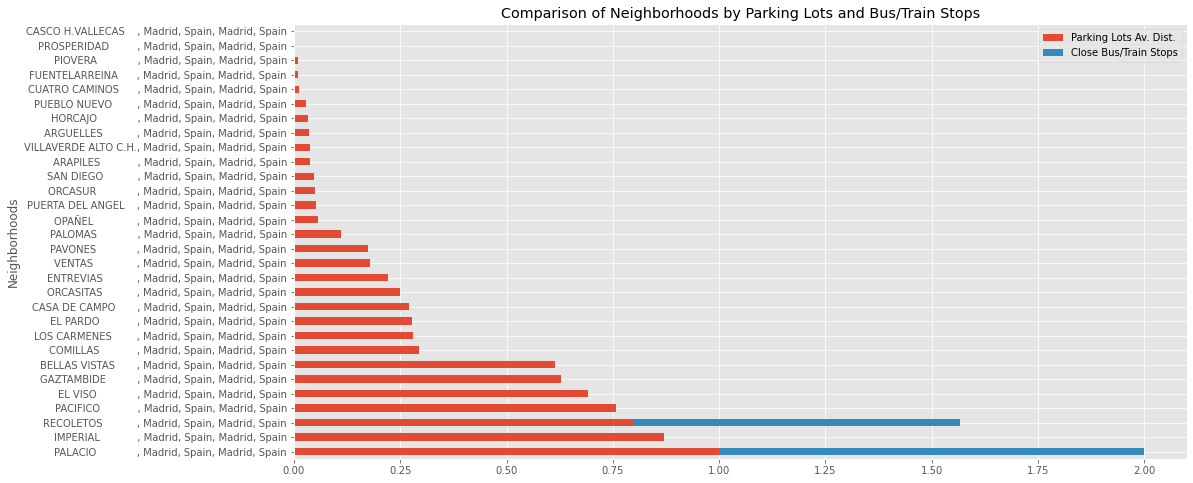

In [69]:
#We can visualize the results in bar plot
df.plot.barh(x="Neighborhood", y=["CarPark_Dist_N", "Close_Bus/Train_N"],stacked=True,figsize=(16,8))
plt.ylabel('Neighborhoods') # x-label to the plot
plt.title('Comparison of Neighborhoods by Parking Lots and Bus/Train Stops') # title to the plot
plt.legend(('Parking Lots Av. Dist.', 'Close Bus/Train Stops'),loc=1) #legend of the plot
plt.show()

In [70]:
#Finally, get the comparison result and save the result in a new dataframe as df_outcome
df['Total']=df['CarPark_Dist_N']+df['Close_Bus/Train_N'] #create a new column
df_outcome=df.sort_values('Total', ascending = False).head(3).reset_index(drop=True) #return the max value 
df_outcome

<ipython-input-70-6e83bd601901>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total']=df['CarPark_Dist_N']+df['Close_Bus/Train_N'] #create a new column


,Neighborhood,Lat,Lon,CarPark_Dist,Close_Bus/Train,CarPark_Dist_N,Close_Bus/Train_N,Total
0,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,1008.48,13,1.000000,1.000000,2.000000
1,"RECOLETOS , Madrid, Spain, Madrid, S...",40.421446,-3.689557,1752.70,10,0.797922,0.769231,1.567152
2,"IMPERIAL , Madrid, Spain, Madrid, S...",40.406845,-3.720088,1483.29,0,0.871075,0.000000,0.871075


In [71]:
print('The top three neighborhoods for a new restaurant in Madrid are:\n {}\n {}\n {}'.\
      format(df_outcome.at[0,'Neighborhood'],df_outcome.at[1,'Neighborhood'],df_outcome.at[2,'Neighborhood']))

The top three neighborhoods for a new restaurant in Madrid are:
 PALACIO             , Madrid, Spain, Madrid, Spain
 RECOLETOS           , Madrid, Spain, Madrid, Spain
 IMPERIAL            , Madrid, Spain, Madrid, Spain


### Detail of parking lots which are below 1000 meters distance for the best neighborhood

In [72]:
n=0
m=0
for m in range(df_park['name'].count()):
    location1=list(df_outcome.loc[0,'Lat':'Lon'])
    location2=list(df_park.loc[m,'lat':'lng'])
    dist=float('%.2f' % geodesic(location1,location2).m)
    #dist_list.append(dist)
    if dist<=1000:
        n+=1
        print('Between {} and {} is {} meters'.format((df_outcome.loc[0,'Neighborhood']),(df_park.at[m,'name']),dist))
    else:
        continue
print('\n There are {} parking lots exist in {} below 1000 meters distance'.format(n,df_outcome.at[0,'Neighborhood']))

Between PALACIO             , Madrid, Spain, Madrid, Spain and Parking Jacinto Benavente is 941.53 meters
Between PALACIO             , Madrid, Spain, Madrid, Spain and Parking Plaza del Carmen is 983.9 meters
Between PALACIO             , Madrid, Spain, Madrid, Spain and Parking Plaza de las Descalzas is 707.19 meters
Between PALACIO             , Madrid, Spain, Madrid, Spain and Parking Plaza Mayor is 679.82 meters
Between PALACIO             , Madrid, Spain, Madrid, Spain and Aparcamiento público is 677.57 meters
Between PALACIO             , Madrid, Spain, Madrid, Spain and Empark Aparcamiento Plaza Mayor is 601.51 meters
Between PALACIO             , Madrid, Spain, Madrid, Spain and Parking Tudescos is 952.42 meters
Between PALACIO             , Madrid, Spain, Madrid, Spain and Parking del Hotel Mercure Santo Domingo is 712.3 meters
Between PALACIO             , Madrid, Spain, Madrid, Spain and Parking Plaza de Oriente is 279.79 meters
Between PALACIO             , Madrid, Spain, 

### Now we can create a map of Madrid with;

* The result (best neighborhood) as RED circle marker
* Parking Lots as BLUE circle markers
* Light Rail/Metro/Train/Tram/Bus Stations as ORANGE circle markers

In [73]:
result_latitude=df_outcome.at[0,'Lat']
result_longitude=df_outcome.at[0,'Lon']
result_name=df_outcome.at[0,'Neighborhood']

result_map = folium.Map(location=[mad_latitude, mad_longitude], zoom_start=14) # generate map centred around Ecco


# show neighborhood as a red circle mark
folium.features.CircleMarker(
    [result_latitude, result_longitude],
    radius=10,
    popup=result_name,
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(result_map)


# add Parking Lots to the map as blue circle markers
for lat, lng, label in zip(df_park.lat, df_park.lng, df_park.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(result_map)
    

# add Light Rail/Metro/Train/Tram/Bus Station to the map as orange circle markers
for lat, lng, label in zip(df_trans_tot.lat, df_trans_tot.lng, df_trans_tot.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='orange',
        fill_color='orange',
        fill_opacity=0.6
        ).add_to(result_map)

# display map
result_map


In [122]:
Image(url= "https://raw.githubusercontent.com/friverap/Coursera_Capstone/main/best_neighborhood.png")

#### Acoording with this preliminary analysis, the best neighborhhood to open a restaurant is Recoletos. Now, we will explore the top 100 venues that are in the neighbourhoods within a radius of 1500 meters from the first thirty negthborhood with better parking lot and bus/train stations.

In [75]:
# Create function that gets the top 100 venues
def getNearbyVenues (names, latitudes, longitudes, radius= 1500):
    
    venue_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venue_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venue_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [76]:
venues = getNearbyVenues(names=df['Neighborhood'],
                               latitudes=df['Lat'],
                               longitudes=df['Lon']
                                  )

PALACIO             , Madrid, Spain, Madrid, Spain
IMPERIAL            , Madrid, Spain, Madrid, Spain
RECOLETOS           , Madrid, Spain, Madrid, Spain
PACIFICO            , Madrid, Spain, Madrid, Spain
EL VISO             , Madrid, Spain, Madrid, Spain
GAZTAMBIDE          , Madrid, Spain, Madrid, Spain
BELLAS VISTAS       , Madrid, Spain, Madrid, Spain
COMILLAS            , Madrid, Spain, Madrid, Spain
LOS CARMENES        , Madrid, Spain, Madrid, Spain
EL PARDO            , Madrid, Spain, Madrid, Spain
CASA DE CAMPO       , Madrid, Spain, Madrid, Spain
ORCASITAS           , Madrid, Spain, Madrid, Spain
ENTREVIAS           , Madrid, Spain, Madrid, Spain
VENTAS              , Madrid, Spain, Madrid, Spain
PAVONES             , Madrid, Spain, Madrid, Spain
PALOMAS             , Madrid, Spain, Madrid, Spain
OPAÑEL              , Madrid, Spain, Madrid, Spain
PUERTA DEL ANGEL    , Madrid, Spain, Madrid, Spain
ORCASUR             , Madrid, Spain, Madrid, Spain
SAN DIEGO           , Madrid, S

In [77]:
venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Palacio Real de Madrid,40.417940,-3.714259,Palace
1,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
2,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Plaza de Oriente,40.418326,-3.712196,Plaza
3,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Teatro Real de Madrid,40.418226,-3.711064,Opera House
4,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Zuccaru,40.417179,-3.711674,Ice Cream Shop
...,...,...,...,...,...,...,...
2273,"CASCO H.VALLECAS , Madrid, Spain, Madrid, S...",40.373977,-3.645339,Pistas De Padel,40.364227,-3.649912,Tennis Court
2274,"CASCO H.VALLECAS , Madrid, Spain, Madrid, S...",40.373977,-3.645339,Diana Plus Hotel Madrid,40.366088,-3.654493,Hotel
2275,"CASCO H.VALLECAS , Madrid, Spain, Madrid, S...",40.373977,-3.645339,Blanco y Negro,40.384859,-3.641491,Spanish Restaurant
2276,"CASCO H.VALLECAS , Madrid, Spain, Madrid, S...",40.373977,-3.645339,E.S. Galp,40.369113,-3.631060,Gas Station


## Explore Restaurants in Madrid
Before we get into clustering, I'm creating a new dataframe with all restaurants data that was returned by Foursquare API. Since some of these venues were double counted, I will drop them in order to make a map of these restaurants.

In [78]:
tapas = venues[venues['Venue Category'].str.contains("Tapas Restaurant")].reset_index(drop=True)
tapas.shape

(85, 7)

In [79]:
tapas

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Taberna Sanlúcar,40.410971,-3.713191,Tapas Restaurant
1,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Casa Lucas,40.412315,-3.709437,Tapas Restaurant
2,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Matritum,40.412178,-3.709223,Tapas Restaurant
3,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Juana la Loca Pintxos-Bar,40.411340,-3.711101,Tapas Restaurant
4,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Taberna Almería,40.410716,-3.712309,Tapas Restaurant
...,...,...,...,...,...,...,...
80,"PROSPERIDAD , Madrid, Spain, Madrid, S...",40.444267,-3.672436,El Rinconcito de Juan,40.448645,-3.675110,Tapas Restaurant
81,"PROSPERIDAD , Madrid, Spain, Madrid, S...",40.444267,-3.672436,Los Torreznos,40.448030,-3.668784,Tapas Restaurant
82,"PROSPERIDAD , Madrid, Spain, Madrid, S...",40.444267,-3.672436,Bar Alonso,40.443216,-3.680265,Tapas Restaurant
83,"PROSPERIDAD , Madrid, Spain, Madrid, S...",40.444267,-3.672436,Txirimiri,40.433264,-3.676507,Tapas Restaurant


In [80]:
# create map of Madrid using latitude and longitude values
food_map = folium.Map(location=[mad_latitude, mad_longitude], zoom_start=11)

# show neighborhood as a red circle mark
folium.features.CircleMarker(
    [result_latitude, result_longitude],
    radius=10,
    popup=result_name,
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(food_map)

# add markers to map
for lat, lng, name in zip(tapas['Venue Latitude'], tapas['Venue Longitude'], tapas['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='lightpink',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(food_map)  
    
food_map

In [123]:
Image(url= "https://raw.githubusercontent.com/friverap/Coursera_Capstone/main/tapas-restaurants.png")

### One Hot Encoding
Previously, we collected data on venues near to Palacio with their names and coordinates. However, to run machine learning algorithms on the data, we need numerical data about the existence of these venues. One hot encoding helps us do that by creating new (binary) columns to indicate the presence of each possible value from the original data. This means that each venue in each neighborhood will be labeled as 1 in their correct category. After this, we group the dataframe by the neighborhoods to get the mean of the frequency of occurence of each venue category.

### 1. Analyze Neighborhoods

In [82]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Entertainment,Asian Restaurant,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Entertainment,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wine Bar,Wine Shop
0,"ARAPILES , Madrid, Spain, Madrid, S...",0.00,0.0,0.01,0.0,0.0,0.00,0.0,0.00,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.01,0.00
1,"ARGUELLES , Madrid, Spain, Madrid, S...",0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.000000,...,0.0,0.01,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.01
2,"BELLAS VISTAS , Madrid, Spain, Madrid, S...",0.01,0.0,0.00,0.0,0.0,0.01,0.0,0.01,0.000000,...,0.0,0.01,0.0,0.00,0.0,0.0,0.01,0.0,0.00,0.00
3,"CASA DE CAMPO , Madrid, Spain, Madrid, S...",0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.020833,...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00
4,"CASCO H.VALLECAS , Madrid, Spain, Madrid, S...",0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.000000,...,0.0,0.00,0.0,0.04,0.0,0.0,0.00,0.0,0.00,0.00


### 2. Tapas Restaurnant One Hot Encoding


In [84]:
res = grouped[['Neighborhood', 'Tapas Restaurant']]
res.head()

,Neighborhood,Tapas Restaurant
0,"ARAPILES , Madrid, Spain, Madrid, S...",0.050000
1,"ARGUELLES , Madrid, Spain, Madrid, S...",0.030000
2,"BELLAS VISTAS , Madrid, Spain, Madrid, S...",0.060000
3,"CASA DE CAMPO , Madrid, Spain, Madrid, S...",0.020833
4,"CASCO H.VALLECAS , Madrid, Spain, Madrid, S...",0.000000


## Machine Learning - Cluster Neighborhoods
We are ready to get into machine learning! For this project, I am using k-means clustering. To begin with, a cluster is a collection of data points aggregated together based on their similarities. Using machine learning algorithms, we can cluster the neighborhoods based on their similarities with each other. K-means algorithm, in particular, first identifies k number of centroids, and then allocates every data point to the cluster, in a way that the data point is closer to that cluster's centroid than any other centroid. K-means algorithm runs this in a repetitive fashion before the centroids are stablized and the clusters are formed. I am using this method because it is an unsupervised learning method meaning that the algorithm will find the similarities betwen the data points for us given we don't know them to begin with.

In [85]:
cluster = res.drop('Neighborhood', 1)
cluster

,Tapas Restaurant
0,0.050000
1,0.030000
2,0.060000
3,0.020833
4,0.000000
5,0.031579
6,0.050000
7,0.083333
8,0.030000
9,0.031250


### Visualize the Average Frequency of tapas Restaurants of Each Neighborhood

([<matplotlib.axis.XTick at 0x7fb05c831820>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

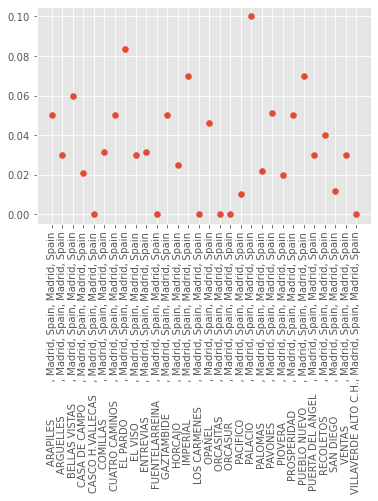

In [86]:
plt.scatter(res['Neighborhood'],res['Tapas Restaurant'])
plt.xticks(res['Neighborhood'], rotation='vertical')

###  Find best K
One limitation of k-means clustering is that the algorithm does not decide how many clusters to form on its own and we need to find the best K to make clustering more accurate. The Elbow Method is one of the most popular methods to determine this optimal value of k. We iterate the values of k from 1 to 10 and calculate the distortion and inertia values for each value of k in the given range. Distortion is the average of the squared distances from the cluster centers of the respective clusters while inertia is the sum of squared distances of samples to their closest cluster center.

1 : 0.021022494122131145
2 : 0.012750075650862102
3 : 0.009517341061170461
4 : 0.0047918505370411
5 : 0.004150403861111666
6 : 0.0026647799547867604
7 : 0.0022480614666640086
8 : 0.0015306718387480657
9 : 0.0010505456095292781


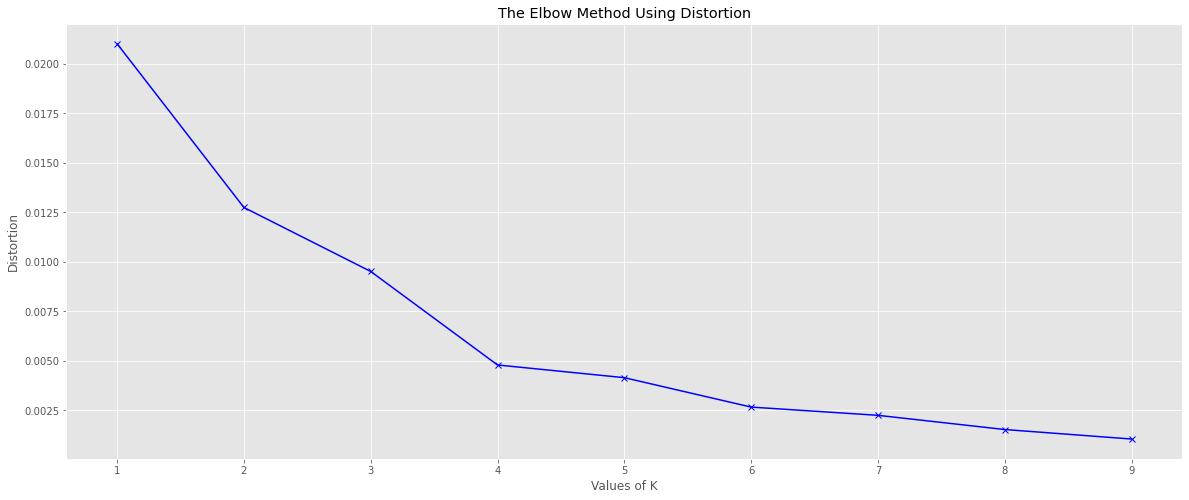

In [97]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(cluster) 
    kmeanModel.fit(cluster)     
      
    distortions.append(sum(np.min(cdist(cluster, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / cluster.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(cluster, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / cluster.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method Using Distortion') 
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

1 : 0.020230838672771406
2 : 0.006420049325426443
3 : 0.0031815044969481774
4 : 0.001198204666260123
5 : 0.0006731757689706387
6 : 0.0004835134639256098
7 : 0.0003255295298616348
8 : 0.00017995326839769426
9 : 0.00011328660173102749


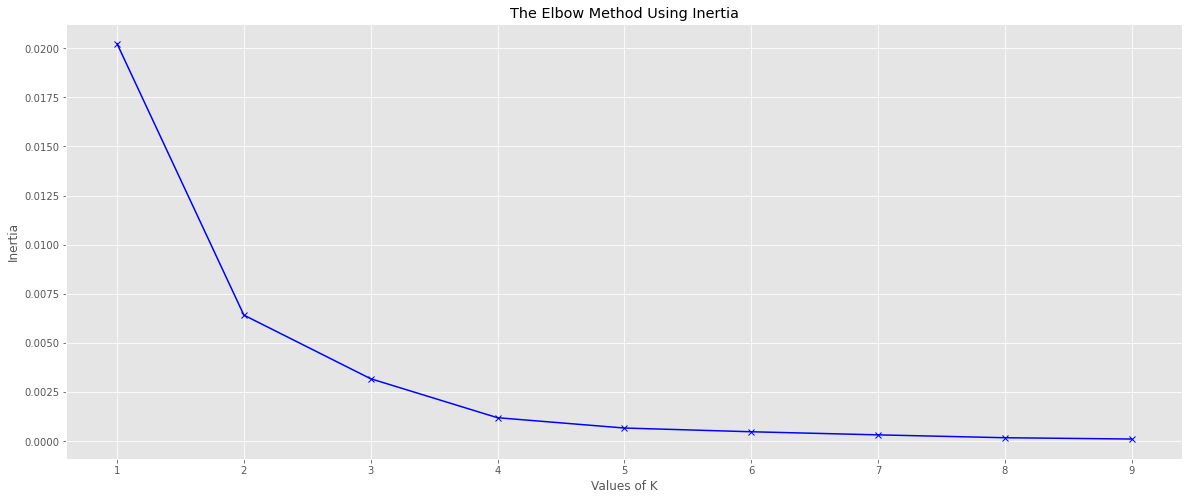

In [96]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method Using Inertia')
plt.rcParams["figure.figsize"] = (20,8) 
plt.show()

To determine the optimal number of K, we select the value of k at the “elbow” of the plots, the point after which the distortion/inertia starts decreasing in a linear fashion. Given these plots, we conclude that 4-6 clusters would work best for our data. Ultimately, I decided to go with 5.


### Visualize Scatterplot with the 5 Clusters

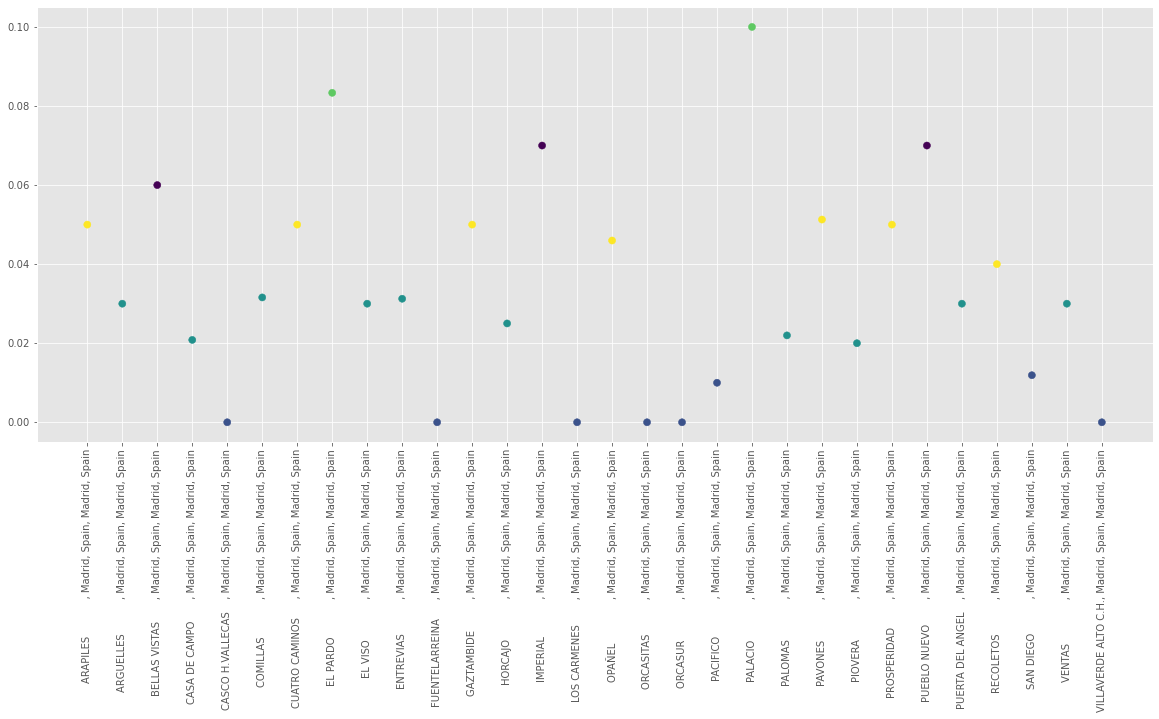

In [98]:
labels = KMeans(5, random_state=0).fit_predict(cluster)
plt.scatter(res['Neighborhood'], res['Tapas Restaurant'], c=labels,
            s=50, cmap='viridis')
plt.xticks(res['Neighborhood'], rotation='vertical')
plt.rcParams["figure.figsize"] = (20,1) 

In [99]:
##Run K-Means to Cluster Neighborhoods
# Run k-means to cluster neighbourhoods into 5 clusters

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[1:10]

array([2, 0, 2, 1, 2, 4, 3, 2, 2], dtype=int32)

In [100]:
res.insert(0, 'Cluster Labels', kmeans.labels_)
res.head()

,Cluster Labels,Neighborhood,Tapas Restaurant
0,4,"ARAPILES , Madrid, Spain, Madrid, S...",0.050000
1,2,"ARGUELLES , Madrid, Spain, Madrid, S...",0.030000
2,0,"BELLAS VISTAS , Madrid, Spain, Madrid, S...",0.060000
3,2,"CASA DE CAMPO , Madrid, Spain, Madrid, S...",0.020833
4,1,"CASCO H.VALLECAS , Madrid, Spain, Madrid, S...",0.000000


In [101]:
# add clustering labels
merged = df
merged = merged.join(res.set_index('Neighborhood'), on='Neighborhood')
merged.head() # check the last columns!

,Neighborhood,Lat,Lon,CarPark_Dist,Close_Bus/Train,CarPark_Dist_N,Close_Bus/Train_N,Total,Cluster Labels,Tapas Restaurant
0,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,1008.48,13,1.000000,1.000000,2.000000,3,0.10
1,"IMPERIAL , Madrid, Spain, Madrid, S...",40.406845,-3.720088,1483.29,0,0.871075,0.000000,0.871075,0,0.07
2,"RECOLETOS , Madrid, Spain, Madrid, S...",40.421446,-3.689557,1752.70,10,0.797922,0.769231,1.567152,4,0.04
3,"PACIFICO , Madrid, Spain, Madrid, S...",40.404145,-3.677941,1902.74,0,0.757181,0.000000,0.757181,1,0.01
4,"EL VISO , Madrid, Spain, Madrid, S...",40.449021,-3.686681,2141.15,0,0.692446,0.000000,0.692446,2,0.03


### Examine Clusters


In [102]:
# Cluster 1
cluster0 = merged.loc[merged['Cluster Labels'] == 0]
cluster0

,Neighborhood,Lat,Lon,CarPark_Dist,Close_Bus/Train,CarPark_Dist_N,Close_Bus/Train_N,Total,Cluster Labels,Tapas Restaurant
1,"IMPERIAL , Madrid, Spain, Madrid, S...",40.406845,-3.720088,1483.29,0,0.871075,0.0,0.871075,0,0.07
6,"BELLAS VISTAS , Madrid, Spain, Madrid, S...",40.453103,-3.708353,2427.76,0,0.614622,0.0,0.614622,0,0.06
24,"PUEBLO NUEVO , Madrid, Spain, Madrid, S...",40.429710,-3.645223,4587.61,0,0.028158,0.0,0.028158,0,0.07


In [103]:
# Cluster 2
cluster1 = merged.loc[merged['Cluster Labels'] == 1]
cluster1

,Neighborhood,Lat,Lon,CarPark_Dist,Close_Bus/Train,CarPark_Dist_N,Close_Bus/Train_N,Total,Cluster Labels,Tapas Restaurant
3,"PACIFICO , Madrid, Spain, Madrid, S...",40.404145,-3.677941,1902.74,0,0.757181,0.0,0.757181,1,0.010000
8,"LOS CARMENES , Madrid, Spain, Madrid, S...",40.401852,-3.736457,3658.90,0,0.280331,0.0,0.280331,1,0.000000
11,"ORCASITAS , Madrid, Spain, Madrid, S...",40.369264,-3.714918,3772.90,0,0.249376,0.0,0.249376,1,0.000000
18,"ORCASUR , Madrid, Spain, Madrid, S...",40.369934,-3.701179,4508.29,0,0.049695,0.0,0.049695,1,0.000000
19,"SAN DIEGO , Madrid, Spain, Madrid, S...",40.385488,-3.668041,4516.48,0,0.047472,0.0,0.047472,1,0.011905
21,"VILLAVERDE ALTO C.H., Madrid, Spain, Madrid, S...",40.339554,-3.717536,4553.86,0,0.037322,0.0,0.037322,1,0.000000
26,"FUENTELARREINA , Madrid, Spain, Madrid, S...",40.480245,-3.740329,4655.33,0,0.009770,0.0,0.009770,1,0.000000
29,"CASCO H.VALLECAS , Madrid, Spain, Madrid, S...",40.373977,-3.645339,4691.31,0,0.000000,0.0,0.000000,1,0.000000


In [104]:
# Cluster 3
cluster2 = merged.loc[merged['Cluster Labels'] == 2]
cluster2

,Neighborhood,Lat,Lon,CarPark_Dist,Close_Bus/Train,CarPark_Dist_N,Close_Bus/Train_N,Total,Cluster Labels,Tapas Restaurant
4,"EL VISO , Madrid, Spain, Madrid, S...",40.449021,-3.686681,2141.15,0,0.692446,0.0,0.692446,2,0.030000
7,"COMILLAS , Madrid, Spain, Madrid, S...",40.392233,-3.714147,3608.01,0,0.294149,0.0,0.294149,2,0.031579
10,"CASA DE CAMPO , Madrid, Spain, Madrid, S...",40.419748,-3.748978,3691.00,0,0.271614,0.0,0.271614,2,0.020833
12,"ENTREVIAS , Madrid, Spain, Madrid, S...",40.380009,-3.671025,3877.24,0,0.221045,0.0,0.221045,2,0.031250
13,"VENTAS , Madrid, Spain, Madrid, S...",40.432136,-3.663291,4031.45,0,0.179172,0.0,0.179172,2,0.030000
15,"PALOMAS , Madrid, Spain, Madrid, S...",40.452659,-3.619886,4283.74,0,0.110668,0.0,0.110668,2,0.021978
17,"PUERTA DEL ANGEL , Madrid, Spain, Madrid, S...",40.409447,-3.730815,4499.26,0,0.052147,0.0,0.052147,2,0.030000
22,"ARGUELLES , Madrid, Spain, Madrid, S...",40.429414,-3.721413,4564.45,0,0.034446,0.0,0.034446,2,0.030000
23,"HORCAJO , Madrid, Spain, Madrid, S...",40.408412,-3.628979,4572.02,0,0.032391,0.0,0.032391,2,0.025000
27,"PIOVERA , Madrid, Spain, Madrid, S...",40.453446,-3.632630,4657.65,0,0.009140,0.0,0.009140,2,0.020000


In [105]:
# Cluster 4
cluster3 = merged.loc[merged['Cluster Labels'] == 3]
cluster3

,Neighborhood,Lat,Lon,CarPark_Dist,Close_Bus/Train,CarPark_Dist_N,Close_Bus/Train_N,Total,Cluster Labels,Tapas Restaurant
0,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,1008.48,13,1.000000,1.0,2.000000,3,0.100000
9,"EL PARDO , Madrid, Spain, Madrid, S...",40.519069,-3.775877,3671.29,0,0.276966,0.0,0.276966,3,0.083333


In [106]:
# Cluster 5
cluster4 = merged.loc[merged['Cluster Labels'] == 4]
cluster4

,Neighborhood,Lat,Lon,CarPark_Dist,Close_Bus/Train,CarPark_Dist_N,Close_Bus/Train_N,Total,Cluster Labels,Tapas Restaurant
2,"RECOLETOS , Madrid, Spain, Madrid, S...",40.421446,-3.689557,1752.70,10,0.797922,0.769231,1.567152,4,0.040000
5,"GAZTAMBIDE , Madrid, Spain, Madrid, S...",40.435416,-3.714341,2379.27,0,0.627789,0.000000,0.627789,4,0.050000
14,"PAVONES , Madrid, Spain, Madrid, S...",40.401226,-3.633296,4050.19,0,0.174084,0.000000,0.174084,4,0.051282
16,"OPAÑEL , Madrid, Spain, Madrid, S...",40.388255,-3.725133,4479.32,0,0.057562,0.000000,0.057562,4,0.045977
20,"ARAPILES , Madrid, Spain, Madrid, S...",40.435125,-3.708651,4553.32,0,0.037468,0.000000,0.037468,4,0.050000
25,"CUATRO CAMINOS , Madrid, Spain, Madrid, S...",40.451479,-3.701554,4651.25,0,0.010878,0.000000,0.010878,4,0.050000
28,"PROSPERIDAD , Madrid, Spain, Madrid, S...",40.444267,-3.672436,4689.01,0,0.000625,0.000000,0.000625,4,0.050000


In [107]:
clusters = merged.groupby('Neighborhood').mean()
clusters.head()

,Lat,Lon,CarPark_Dist,Close_Bus/Train,CarPark_Dist_N,Close_Bus/Train_N,Total,Cluster Labels,Tapas Restaurant
Neighborhood,,,,,,,,,
"ARAPILES , Madrid, Spain, Madrid, Spain",40.435125,-3.708651,4553.32,0,0.037468,0.0,0.037468,4,0.050000
"ARGUELLES , Madrid, Spain, Madrid, Spain",40.429414,-3.721413,4564.45,0,0.034446,0.0,0.034446,2,0.030000
"BELLAS VISTAS , Madrid, Spain, Madrid, Spain",40.453103,-3.708353,2427.76,0,0.614622,0.0,0.614622,0,0.060000
"CASA DE CAMPO , Madrid, Spain, Madrid, Spain",40.419748,-3.748978,3691.00,0,0.271614,0.0,0.271614,2,0.020833
"CASCO H.VALLECAS , Madrid, Spain, Madrid, Spain",40.373977,-3.645339,4691.31,0,0.000000,0.0,0.000000,1,0.000000


In [108]:
c0 = clusters.loc[clusters['Cluster Labels'] == 0]
c1 = clusters.loc[clusters['Cluster Labels'] == 1]
c2 = clusters.loc[clusters['Cluster Labels'] == 2]
c3 = clusters.loc[clusters['Cluster Labels'] == 3]
c4 = clusters.loc[clusters['Cluster Labels'] == 4]

In [109]:
print('Cluster 0 has an average frequency of Tapas Restaurants of', c0["Tapas Restaurant"].mean())
print('Cluster 1 has an average frequency of Tapas Restaurants of', c1["Tapas Restaurant"].mean())
print('Cluster 2 has an average frequency of Tapas Restaurants of', c2["Tapas Restaurant"].mean())
print('Cluster 3 has an average frequency of Tapas Restaurants of', c3["Tapas Restaurant"].mean())
print('Cluster 4 has an average frequency of Tapas Restaurants of', c4["Tapas Restaurant"].mean())

Cluster 0 has an average frequency of Tapas Restaurants of 0.06666666666666667
Cluster 1 has an average frequency of Tapas Restaurants of 0.0027380952380952383
Cluster 2 has an average frequency of Tapas Restaurants of 0.027064030267977636
Cluster 3 has an average frequency of Tapas Restaurants of 0.09166666666666667
Cluster 4 has an average frequency of Tapas Restaurants of 0.04817986611090059


#### After looking at each cluster, we can conclude that Cluster 3 has the highest frequency of Tapas restaurants while Cluster 1 has the lowest.

## Data Visualization

In [110]:
#Let's create a map to examine these clusters further.
import matplotlib.colors as colors

map_clusters = folium.Map(location=[mad_latitude, mad_longitude], zoom_start=11)

# show the Palacio neighborhood as a red circle mark
folium.features.CircleMarker(
    [result_latitude, result_longitude],
    radius=10,
    popup=result_name,
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
#markers_colors = []
for lat, lng, name, cluster, in zip(merged['Lat'], merged['Lon'], merged['Neighborhood'],  
                                            merged['Cluster Labels']):
    label = folium.Popup(name + '- Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        tooltip = name + '- Cluster ' + str(cluster),
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

In [124]:
Image(url= "https://raw.githubusercontent.com/friverap/Coursera_Capstone/main/map-closter.png")

* Cluster 0 = Orange 
* Cluster 1 = Red 
* Cluster 2 = Purple 
* Cluster 3 = Blue 
* Cluster 4 = Green
* Palacio Neighborhood = big red point

Let's calculate the number of neighborhoods in each closter and also the number of restaurants in each cluster

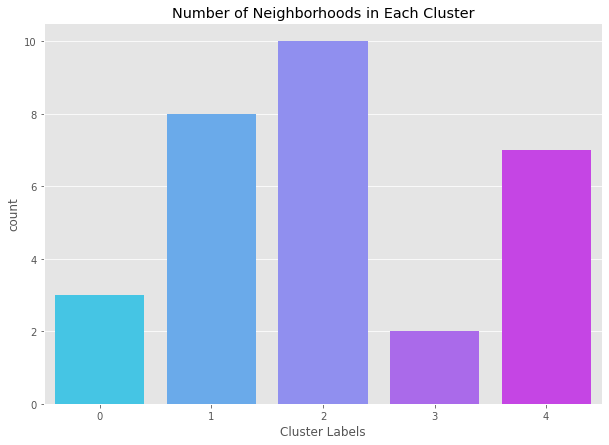

In [112]:
plt.style.use('seaborn-pastel')
plt.rcParams['figure.figsize'] = (10, 7)

ax = sns.countplot(x=clusters['Cluster Labels'],data=clusters, palette = 'cool').set_title("Number of Neighborhoods in Each Cluster")

In this graph we can see that the  cluster with the biggest number of neighborhoods is the cluster 2. On the other  hand, the cluster with lowest number of neighborhoods is the cluster 3.

Now we calculate the approximate Number of Tapas Restaurants in Each Cluster

In [113]:
f = tapas.join(res.set_index('Neighborhood'), on='Neighborhood')
f.reset_index(drop = True)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Tapas Restaurant
0,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Taberna Sanlúcar,40.410971,-3.713191,Tapas Restaurant,3,0.10
1,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Casa Lucas,40.412315,-3.709437,Tapas Restaurant,3,0.10
2,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Matritum,40.412178,-3.709223,Tapas Restaurant,3,0.10
3,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Juana la Loca Pintxos-Bar,40.411340,-3.711101,Tapas Restaurant,3,0.10
4,"PALACIO , Madrid, Spain, Madrid, S...",40.416339,-3.714318,Taberna Almería,40.410716,-3.712309,Tapas Restaurant,3,0.10
...,...,...,...,...,...,...,...,...,...
80,"PROSPERIDAD , Madrid, Spain, Madrid, S...",40.444267,-3.672436,El Rinconcito de Juan,40.448645,-3.675110,Tapas Restaurant,4,0.05
81,"PROSPERIDAD , Madrid, Spain, Madrid, S...",40.444267,-3.672436,Los Torreznos,40.448030,-3.668784,Tapas Restaurant,4,0.05
82,"PROSPERIDAD , Madrid, Spain, Madrid, S...",40.444267,-3.672436,Bar Alonso,40.443216,-3.680265,Tapas Restaurant,4,0.05
83,"PROSPERIDAD , Madrid, Spain, Madrid, S...",40.444267,-3.672436,Txirimiri,40.433264,-3.676507,Tapas Restaurant,4,0.05


Text(0.5, 1.0, 'Approximate Number of Tapas Restaurants in Each Cluster')

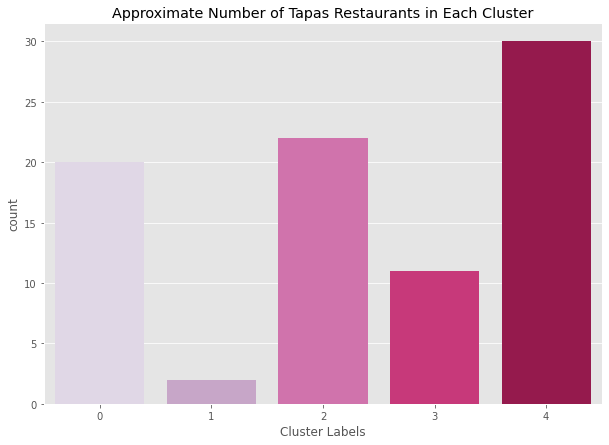

In [114]:
plt.style.use('seaborn-pastel')
plt.rcParams['figure.figsize'] = (10, 7)

sns.countplot(x=f['Cluster Labels'],data=f, palette = 'PuRd').set_title("Approximate Number of Tapas Restaurants in Each Cluster")

In this graph we can see the approximate number of Tapas restaurants in each cluster. Cluster 4 and cluster 2 have the higher number of tapas restaurant.

### Discussion and Conclusions

In this project, we want to determine the best neighborhood in Madrid for the entrepreneurs to open a tapas restaurant. For this aim, we get the neighborhoods list of Madrid and then we use the Google Geoencoding API to find the approximate coordinates of the neighborhoods.

For comparison between the neighborhoods, we need "Parking Lots" list and "Metro/Train/Tram/Bus Station list" with their geolocations. We get these datas via Foursquare Api. In Foursquare web site, we learned that the categoryId of our venues' (Parking, Metro Station, Tram Station and Bus Station) categoryIds and use these Ids to get and create the datasets. As we know, Foursquare API has a response limit (the number of venues returned by Foursquare API has a maximum limit is 100) of queries. Because of there are more than 100 Bus/Train Stops in Madrid, we tried to send query with sub-categoryIDs of venues and update the dataframe with "for loop" with 1000 meters radius easily.

Then, we calculate the average distance of all "parking lot" for each neighborhood and calculate the total "Metro/Train/Tram/Bus Station number" below than 1000 meters for each neighborhood.

After compare the neighborhoods with these two factor, we reach that The best neighborhood for a new restaurant in Madrid is: PALACIO.

Palacio has: 
* 13 public transport (Metro/Train/Tram/Bus) Stations in 1 km of distance.
* The average distance for 17 Parking Lots is arround 1 km.

During our cluster analysis, we found that Cluster 1 has the lowest average frequency of tapas restaurants while Cluster 3 has the highest. However, Cluster 4 has the highest number of tapas restaurants, with a lower average frequency, which might be because Cluster 4 has a high number of neighborhoods compared to other clusters, and that there are other common venues in the neighborhood which makes the frequency of tapas restaurants lower. On the other hand, cluster 3 has only two neighborhood, these are: Palacio and El Pardo.

Based on  the  previous result, we  can conclude that the better place to open a new tapas restaurant is in the Palacio's neighborhood. That is because it has the closest public transport station as well as the closest parking lots.


### Final comments

It is only a exploratory project and it is not claimed that the result of the project is 100% proper for trade and investing industry. The project framework needs more thinking and planning with systematically. And also the project needs more datasets, field and market research.

we should also note some limitations to this analysis. To start with, the Foursquare API limit to return only the top 100 venues within the radius of 1500 meters. But the neighborhoods are very different in shapes and sizes. Some neighborhoods are much larger but less populated while others are more densely populated with a smaller area. Thus, the Foursquare API might not have been able to capture all the tapas restaurants in each neighborhood. However, we calculated the frequency of these restaurants within the 1500 meter radius, which could still reflect the average frequency of tapas restaurants witin that neighborhood. Thus, before opening a restaurant, it might be better to do some research on that specific neighborhood, for example, on its commercial pricing, consumers, competitors, and take other factors into consideration. Here a list of some upgrades to do:

1. We need different type of data like usage density of every streets, frequently preferred routes and the preferred reason.

2. Field research is also important. For instance, a restaurant has 10 parking lots in too close distance but they haven't got enough capacity so most of time it has no free parking lot. So here 10 close parking lots couldn't add positive effect to make a decision. 

3. Taxes are another an important factor in determining the best location. So, we need extra datasets.

4. More data about the neighborhood. For instances, bad smell in the area, construction in the street, closely a loud venue.

So the project has insufficiencies.
